In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.weightstats import ttest_ind
import seaborn as sns

In [2]:
def proportion_ci(series):
    series_size = len(series)
    p_series = series.sum() / series_size
    
    se = np.sqrt(p_series * (1 - p_series) / series_size)
    
    return (p_series - 1.96 * se, p_series + 1.96 * se)

In [3]:
def proportion_diff_ci(test, control):
    test_size = len(test)
    cntrl_size = len(control)
    
    p_test_est = test.sum() / test_size
    p_cntrl_est = control.sum() / cntrl_size
    
    se = np.sqrt(p_cntrl_est * (1 - p_cntrl_est) / cntrl_size + p_test_est * (1 - p_test_est) / test_size)
    
    return (p_test_est - p_cntrl_est - 1.96 * se, p_test_est - p_cntrl_est + 1.96 * se)

In [4]:
def mean_ci(series):
    se = np.std(series, ddof=1) / np.sqrt(series.count())
    
    return (np.mean(series) - 1.96 * se, np.mean(series) + 1.96 * se)

In [5]:
def mean_diff_ci(test, control):
    test_size = len(test)
    cntrl_size = len(control)
    
    test_var = np.var(test, ddof=1)
    cntrl_var = np.var(control, ddof=1)
    
    sp = np.sqrt((test_var * (test_size - 1) + cntrl_var * (test_var - 1)) / (test_size + cntrl_size - 2))
    se = sp * np.sqrt(1 / test_size + 1 / cntrl_size)
    
    return (test.mean() - control.mean() - 1.96 * se, test.mean() - control.mean() + 1.96 * se)

In [6]:
def proportion_test(test_group, control_group):
    stat, pval = proportions_ztest(
        [test_group.sum(), control_group.sum()],
        [len(test_group),len(control_group)]
    )

    print("2-sample test for equality of proportions")
    print("test statistic =", stat)
    print("p-value =", pval)
    
    print("test conversion =", test_group.sum() / len(test_group))
    print("test ci =", proportion_ci(test_group))
    
    print("control conversion =", control_group.sum() / len(control_group))
    print("control ci =", proportion_ci(control_group))
    
    print("ci for diff =", proportion_diff_ci(test_group, control_group))

In [7]:
def mean_test(test_group, control_group):
    t_res = ttest_ind(test_group, control_group, usevar="pooled")
    mw_res = mannwhitneyu(test_group, control_group, alternative='two-sided')

    print("Two Sample t-test")
    print("t =", t_res[0])
    print("p-value =", t_res[1])
    print("df = ", t_res[2])
    
    print("test mean =", test_group.mean())
    print("test ci =", mean_ci(test_group))
    
    print("control mean =", control_group.mean())
    print("control ci =", mean_ci(control_group))
    
    print("ci for diff =", mean_diff_ci(test_group, control_group))
    print()
    
    print("Mann-Whitney rank test")
    print("u =", mw_res[0])
    print("p-value =", mw_res[1])

### Загрузка данных

In [8]:
df = pd.read_csv('hw2_1.csv', sep=';', decimal=',', index_col=0)

In [9]:
df.head()

,date,deviceCategory,sourceMedium,experimentVariant,clickButtonOnMain,sessionDuration
1,2019-11-27,desktop,(direct) / (none),control,1,123.109765
2,2019-11-27,mobile,maz.com / referral,test,1,135.604001
3,2019-11-27,mobile,(direct) / (none),test,1,134.451017
4,2019-11-27,desktop,google / organic,test,1,130.691087
5,2019-11-27,mobile,google / organic,control,1,117.617311


### Оцениваем метрики в разрезе группы теста и устройства

In [10]:
df.groupby(by='experimentVariant', as_index=False).agg({
    'date': 'count',
    'clickButtonOnMain': lambda x: (x.sum(), round(x.sum() / x.count() if x.count() > 0 else 1, 4)),
    'sessionDuration': 'mean',
})

,experimentVariant,date,clickButtonOnMain,sessionDuration
0,control,1485,"(192, 0.1293)",120.038040
1,test,1458,"(133, 0.0912)",133.059223


In [11]:
df.groupby(by=['experimentVariant', 'deviceCategory'], as_index=False).agg({
    'date': 'count',
    'clickButtonOnMain': lambda x: (x.sum(), round(x.sum() / x.count() if x.count() > 0 else 1, 4)),
    'sessionDuration': 'mean',
})

,experimentVariant,deviceCategory,date,clickButtonOnMain,sessionDuration
0,control,desktop,562,"(69, 0.1228)",119.850321
1,control,mobile,857,"(111, 0.1295)",120.217158
2,control,tablet,66,"(12, 0.1818)",119.310662
3,test,desktop,507,"(51, 0.1006)",133.410753
4,test,mobile,885,"(73, 0.0825)",132.890708
5,test,tablet,66,"(9, 0.1364)",132.618459


### Конверсия в отправку формы на всех платформах

In [12]:
proportion_test(
    df[df['experimentVariant'] == 'test']['clickButtonOnMain'],
    df[df['experimentVariant'] == 'control']['clickButtonOnMain']
)

2-sample test for equality of proportions
test statistic = -3.294710114036112
p-value = 0.0009852325829367897
test conversion = 0.09122085048010974
test ci = (0.07644156136368165, 0.10600013959653783)
control conversion = 0.1292929292929293
control ci = (0.11222753733250257, 0.14635832125335602)
ci for diff = (-0.06064761844202814, -0.015496539183610977)


### Конверсия в отправку формы на desktop

In [13]:
proportion_test(
    df[(df['experimentVariant'] == 'test') & (df['deviceCategory'] == 'desktop')]['clickButtonOnMain'],
    df[(df['experimentVariant'] == 'control') & (df['deviceCategory'] == 'desktop')]['clickButtonOnMain']
)

2-sample test for equality of proportions
test statistic = -1.1473047093588644
p-value = 0.2512557083508541
test conversion = 0.10059171597633136
test ci = (0.07440918405219962, 0.1267742479004631)
control conversion = 0.12277580071174377
control ci = (0.09564268899270595, 0.14990891243078158)
ci for diff = (-0.059889929501389536, 0.015521760030564727)


### Конверсия в отправку формы на mobile

In [14]:
proportion_test(
    df[(df['experimentVariant'] == 'test') & (df['deviceCategory'] == 'mobile')]['clickButtonOnMain'],
    df[(df['experimentVariant'] == 'control') & (df['deviceCategory'] == 'mobile')]['clickButtonOnMain']
)

2-sample test for equality of proportions
test statistic = -3.1931638123472808
p-value = 0.001407230913915559
test conversion = 0.08248587570621468
test ci = (0.06436076741577745, 0.10061098399665191)
control conversion = 0.1295215869311552
control ci = (0.10704058092728708, 0.15200259293502333)
ci for diff = (-0.07591330083152006, -0.01815812161836097)


### Среднее время сессии на всех платформах

In [15]:
mean_test(
    df[df['experimentVariant'] == 'test']['sessionDuration'],
    df[df['experimentVariant'] == 'control']['sessionDuration']
)

Two Sample t-test
t = 45.53106041092407
p-value = 0.0
df =  2941.0
test mean = 133.05922272430436
test ci = (132.56131825826859, 133.55712719034014)
control mean = 120.03803959554634
control ci = (119.7743992285828, 120.30167996250988)
ci for diff = (12.523347149096146, 13.519019108419904)

Mann-Whitney rank test
u = 1905573.0
p-value = 2.8172887000279137e-279


### Среднее время сессии на desktop

In [16]:
mean_test(
    df[(df['experimentVariant'] == 'test') & (df['deviceCategory'] == 'desktop')]['sessionDuration'],
    df[(df['experimentVariant'] == 'control') & (df['deviceCategory'] == 'desktop')]['sessionDuration']
)

Two Sample t-test
t = 28.644042593380306
p-value = 2.5731879556011454e-134
df =  1067.0
test mean = 133.41075258021323
test ci = (132.55424763559262, 134.26725752483384)
control mean = 119.85032132221411
control ci = (119.42638665043624, 120.27425599399199)
ci for diff = (12.726303681200454, 14.394558834797772)

Mann-Whitney rank test
u = 251692.0
p-value = 3.9901693702571807e-104


### Среднее время сессии на mobile

In [17]:
mean_test(
    df[(df['experimentVariant'] == 'test') & (df['deviceCategory'] == 'mobile')]['sessionDuration'],
    df[(df['experimentVariant'] == 'control') & (df['deviceCategory'] == 'mobile')]['sessionDuration']
)

Two Sample t-test
t = 33.718641725017214
p-value = 3.09009035154426e-192
df =  1740.0
test mean = 132.89070832353067
test ci = (132.2512545694792, 133.53016207758216)
control mean = 120.2171581593434
control ci = (119.86448275459774, 120.56983356408905)
ci for diff = (12.01371533833574, 13.333384990038812)

Mann-Whitney rank test
u = 663248.0
p-value = 2.870742082664026e-161


### Визуализируем выбросы среднего времени сессии

In [18]:
np.percentile(df[df['experimentVariant'] == 'test']['sessionDuration'], [0, 5, 50, 90, 95, 99, 100])

array([102.340016  , 116.52925836, 133.11172799, 145.79631552,
       149.02544637, 154.43514212, 163.63065065])

In [19]:
np.percentile(df[df['experimentVariant'] == 'control']['sessionDuration'], [0, 5, 50, 90, 95, 99, 100])

array([100.23800079, 111.27872931, 120.1164634 , 126.55409244,
       128.34423387, 131.55242547, 134.80609643])

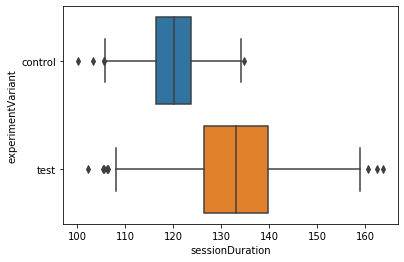

In [20]:
ax = sns.boxplot(x="sessionDuration", y="experimentVariant", data=df)

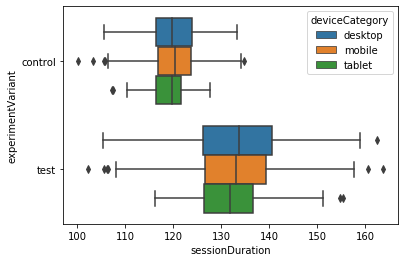

In [21]:
ax = sns.boxplot(x="sessionDuration", y="experimentVariant", hue="deviceCategory", data=df)